# GAN for MNIST and Fashion datasets

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import DataLoader

import time
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import Image
from IPython.display import Image, display
import PIL
import imageio
import glob

import tensorflow_docs.vis.embed as embed

## 1. Data preparation

Create several transformations on the dataset:
- `ToTensor` translates images to [0, 1]
- `Normalize` subtracts mean and divides by std to get images in range [-1,1]

In [2]:
t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

In [ ]:
mnist = torchvision.datasets.MNIST(root="./data/mnist", train=True, transform=t, download=True)
fashion = torchvision.datasets.FashionMNIST(root="./data/fashion_mnist", train=True, transform=t, download=True)

In [5]:
!mkdir ./mnist
!mkdir ./fashion

In [3]:
BATCH_SIZE = 256

Create dataloader to be able to iterate through samples:

In [7]:
dataloader_mnist = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)
dataloader_fashion = DataLoader(fashion, batch_size=BATCH_SIZE, shuffle=True)

## 2. Create GAN model

### How GAN is actually working?

![GAN training process](./images/IMG_B0BE33B1D528-1.jpeg)

2-step process:
1. We want to learn a mapping from an arbitrary distribution (usually normal) $p(\vec{z})$ to our data distribution $p_{data}(\vec{x})$, so that we could sample from $p(\vec{z})$ afterwards and get valid results.
2. We don't know how to formulate the onjective, for this reason we train another model (**disciminator**) to differentiate between $p_{data}(\vec{x_{real}})$ and $p_{data}(\vec{x_{fake}})$.
3. With the help of discriminator now we can backpropagate gradients to **generator**.

### Generator and Discriminator

Let's firstly create the generator model

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Sequential(
            *[
                nn.Linear(input_size, 7*7*256, bias=False),
                nn.BatchNorm1d(7*7*256),
                nn.LeakyReLU(),

            ]
        )
        self.ct1 = nn.Sequential(
            *[
                nn.ConvTranspose2d(256, 128, kernel_size=(5,5), stride=1, padding=2, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
            ]
        )
        """Calculate the needed padding to keep only doubling the spatial dimensions"""
        padding = 2
        output_padding = 1
        self.ct2 = nn.Sequential(
            *[
                nn.ConvTranspose2d(128, 64, kernel_size=(5,5), stride=(2,2), padding=padding, output_padding=output_padding, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(64, 1, kernel_size=(5,5), stride=(2,2), padding=padding, output_padding=output_padding, bias=False),
                # Tanh is used because it's range is [-1;1], it's zero centered and we have smooth gradients
                nn.Tanh(),
            ]
        )

    def forward(self, z):
        z = self.fc1(z)
        z = z.view(-1, 256, 7, 7)
        z = self.ct1(z)
        z = self.ct2(z)
        return z

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), stride=(2,2), padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=(5,5), stride=(2,2), padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(7*7*128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

Some important notes:
1. `LeakyReLu` as activation funtion in `Generators` and `Discriminators` could be used to mitigate the **vanishing gradient problem**.
2. In our version we use `Transposed Convolution` layers (like in vanilla `DCGAN`), although other upsampling techniques could be used (may be not so efficient although).

**Why vanishing gradients could be a problem in a GAN? And how is it connected with the vanilla loss?**
Let's imagine that our discriminator learns to (almost) perfectly classify *real* and *fake* images and look at how its `Sigmoid` looks like:

![Sigmoid](./images/IMG_C2C2FBC2FAE4-1.jpeg)

The gradient from such examples will be very low and the learning process for the `Generator` will last long.

### Theoretical retreat for loss
**Optimization problem**:
$$
\min_G \max_D V(G, D) = \min_G \max_D \mathbb{E}_{x ~ p_{data}(x)}[\log{D(x)}] +\mathbb{E}_{z ~ p_{z}(z)}[\log{1 - D(G(x))}]
$$
But how does it look like in code? Let's look at `Binary Cross Entropy` for a second (for one sample):
$$
L_{BCE} = -(y_{label} \cdot \log(y_{prob}) + (1 - y_{label}) \cdot \log(1 - y_{prob}))
$$
**Discriminator**:
For real part $y == 1$
$$
L_{D_{real}} = -1 \cdot \log[D(x)] = - \log[D(x)]
$$
For a fake part $y == 0$:
$$
L_{D_{fake}} = -0 \cdot \log[D(G(z)] - 1 \cdot \log[1 - D(G(z))] = - \log[1 - D(G(z))]
$$

Then:
$$
L_D = L_{D_{real}} + L_{D_{fake}} = - \log[D(x)] - \log[1 - D(G(z))] == V(G, D)
$$

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = F.binary_cross_entropy(real_output, torch.ones_like(real_output))
    fake_loss = F.binary_cross_entropy(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

For the **generator** we have only fake part and $y == 1$ for it:
$$
L_{G_{fake}} = -1 \cdot \log[D(G(z))] - 0 \cdot log[D(G(z))] = - \log[D(G(z))]
$$
Notice that generator loss contradicts one part of discriminator loss, that's why it's a min/max formulation of the problem.

In [7]:
def generator_loss(fake_output):
    return F.binary_cross_entropy(fake_output, torch.ones_like(fake_output))

### Some support code

In [8]:
def generate_and_save_images(model, epoch, test_input, dataset_name="mnist"):
  # Notice `training` is set to False.
  # This is for all layers to run in inference mode (batchnorm).
  model.eval()
  with torch.no_grad():
    predictions = model(test_input).cpu().detach().numpy()

  model.train()
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, 0, :, :] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('./{}/image_at_epoch_{:04d}.png'.format(dataset_name, epoch))
  plt.show()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
noise_dim = 100
EPOCHS = 70
num_examples_to_generate = 16
seed = torch.randn((num_examples_to_generate, noise_dim)).to(device)

cpu


### Training process code

In [10]:
def train_step(discriminator, generator, batch, device):
    noise = torch.randn((BATCH_SIZE, noise_dim)).to(device)

    generated_imgs = generator(noise)

    real_out = discriminator(batch)
    #Detaching is very important in case of using generated imaged in discriminator
    fake_out = discriminator(generated_imgs)
    fake_out_for_disc = discriminator(generated_imgs.detach())

    gen_loss = generator_loss(fake_out)
    discr_loss = discriminator_loss(real_out, fake_out_for_disc)

    return gen_loss, discr_loss

In [11]:
def save_models(discriminator, generator, epoch, dataset_name="mnist"):
    checkpoint = {
        'epoch': epoch + 1,
        'model1_state_dict': discriminator.state_dict(),
        'model2_state_dict': generator.state_dict(),
    }

    # Define the checkpoint file path
    checkpoint_path = f'{dataset_name}_models_checkpoint_epoch_{epoch + 1}.pth'

    # Save the checkpoint
    torch.save(checkpoint, checkpoint_path)

In [12]:
def train(discriminator, generator, discr_opt, gen_opt, dataloader, seed, device, epochs=EPOCHS, dataset_name="mnist"):
    discriminator.train()
    generator.train()
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        start_time = time.time()

        counter = 0
        epoch_total_gen_loss = 0
        epoch_total_discr_loss = 0

        for (image_batch, labels) in dataloader:
            #train step
            gen_loss, discr_loss = train_step(discriminator, generator, image_batch.to(device), device)
            #losses for stats
            epoch_total_gen_loss += gen_loss.detach().cpu().numpy().item()
            epoch_total_discr_loss += discr_loss.detach().cpu().numpy().item()
            #Generator training
            gen_opt.zero_grad()
            gen_loss.backward()
            gen_opt.step()
            #Discriminator training
            discr_opt.zero_grad()
            discr_loss.backward()
            discr_opt.step()

            counter += 1


        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed.to(device), dataset_name=dataset_name)
        #Bad to use counter as here, but enough for understanding
        current_generator_loss = epoch_total_gen_loss / counter
        current_discriminator_loss = epoch_total_discr_loss / counter
        generator_losses.append(current_generator_loss)
        discriminator_losses.append(current_discriminator_loss)
        print(f"Epoch {epoch + 1} gen loss: {current_generator_loss}")
        print(f"Epoch {epoch + 1} discr loss: {current_discriminator_loss}")

        if (epoch + 1) % 15 == 0:
            save_models(discriminator, generator, epoch, dataset_name=dataset_name)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start_time))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    return generator_losses, discriminator_losses

### Training on MNIST

In [28]:
g = Generator(noise_dim).to(device)
d = Discriminator().to(device)

g_opt = torch.optim.Adam(g.parameters(), lr=3e-4)
d_opt = torch.optim.Adam(d.parameters(), lr=3e-4)

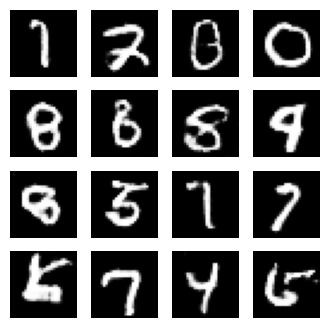

In [29]:
generator_losses, discriminator_losses = train(d, g, d_opt, g_opt, dataloader_mnist, seed, device, EPOCHS)

In [41]:
save_models(d, g, 70, dataset_name="mnist")

### Losses

In [19]:
def plot_losses(generator_losses, discriminator_losses):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title("Losses")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.plot(generator_losses, label="Generator")
    ax.plot(discriminator_losses, label="Discriminator")
    ax.grid()
    plt.show()

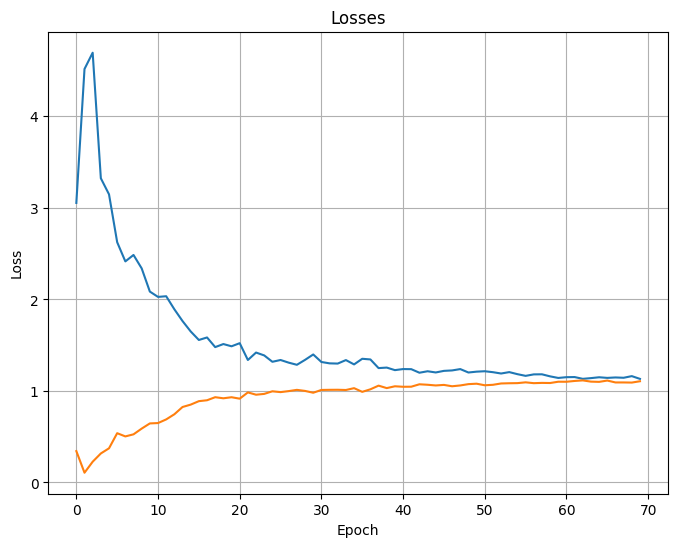

In [34]:
plot_losses(generator_losses, discriminator_losses)

- At the start **generator** generates samples that are different from $p_{data}(\vec{x_{real}})$, that's why the initial **discriminator** loss may be very low and generator loss may be large.
- Gradually generator improves, which makes the task of discriminator much harder.
- After many iterations both reach a plateau. Ideally generator's loss should be very low, while discriminator uncertainty is maximized (loss ~ 0.5). But in reality it's an almost unrealistic scenario.

### Load model

In [30]:
checkpoint_path = "mnist_models_checkpoint_epoch_71.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))

g = Generator(noise_dim).to(device)

# Load the state dictionaries into the models
g.load_state_dict(checkpoint['model2_state_dict'])
# Do not forget to do this! Layers behave differently during training and evaluation
# Even torch.no_grad() won't help
g.eval();

In [13]:
def display_image(epoch_no, dataset_name="mnist"):
  return PIL.Image.open('./{}/image_at_epoch_{:04d}.png'.format(dataset_name, epoch_no))

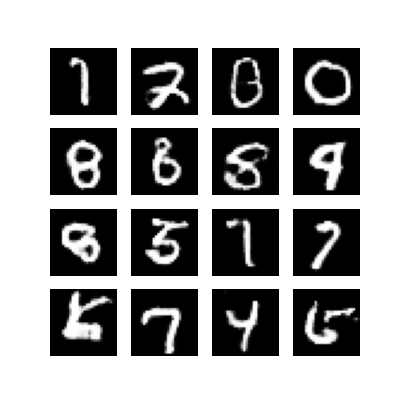

In [36]:
display_image(EPOCHS)

In [14]:
def create_gif(dataset_name="mnist"):
    anim_file = f'{dataset_name}.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(f'./{dataset_name}/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    return anim_file


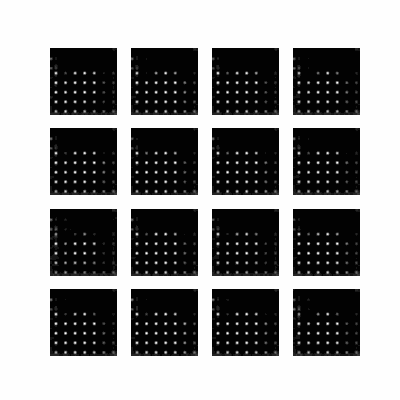

In [38]:
#embed.embed_file(create_gif("mnist"))
embed.embed_file("mnist.gif")

### Interpolation along z-axis

In [18]:
def interpolate(z1, z2, steps=10):
    interpolation = torch.linspace(0, 1, steps)[:, None].to(device)
    return z1 + interpolation * (z2 - z1)

In [19]:
def z_axis_interpolation(g, seed, num_steps_per_interpolation=5):
    generated_images_list = []
    for i in range(num_examples_to_generate - 1):
        z1 = seed[i]
        z2 = seed[i + 1]
        interpolated_z_points = interpolate(z1, z2, steps=num_steps_per_interpolation)

        # Generate images for the interpolated z-points
        with torch.no_grad():
            generated_images = g(interpolated_z_points)
        generated_images_list.append(generated_images)

    # Visualize the generated images
    fig, axs = plt.subplots(num_examples_to_generate - 1, num_steps_per_interpolation, figsize=(15, 8))

    for i in range(num_examples_to_generate - 1):
        for j in range(num_steps_per_interpolation):
            img = generated_images_list[i][j].squeeze().cpu() * 127.5 + 125.7
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')

    plt.show()

In [45]:
sample = torch.randn((num_examples_to_generate, noise_dim)).to(device)

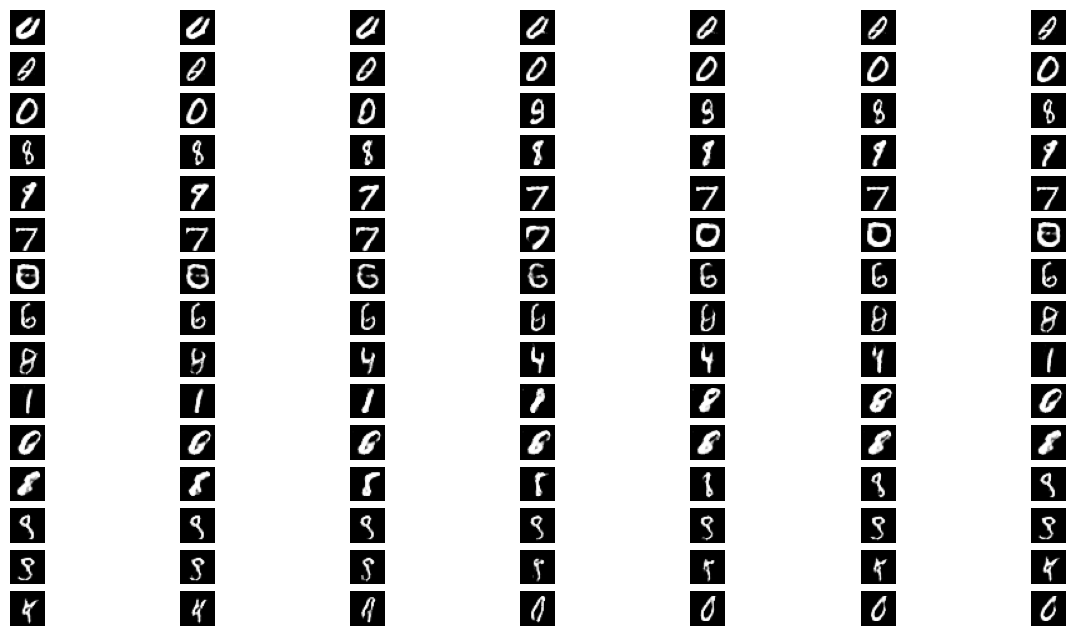

In [46]:
z_axis_interpolation(g, sample, 7)

### Fashion MNIST

In [17]:
g = Generator(noise_dim).to(device)
d = Discriminator().to(device)

g_opt = torch.optim.Adam(g.parameters(), lr=3e-4)
d_opt = torch.optim.Adam(d.parameters(), lr=3e-4)

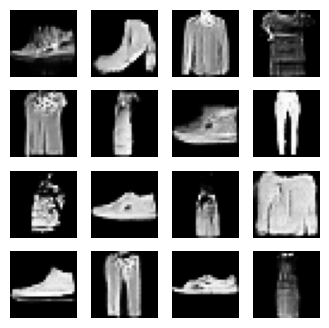

In [18]:
generator_losses, discriminator_losses = train(d, g, d_opt, g_opt, dataloader_fashion, seed, device, EPOCHS, dataset_name="fashion")

In [24]:
save_models(d, g, 70, dataset_name="fashion")

In [20]:
checkpoint_path = "fashion_models_checkpoint_epoch_71.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))

g = Generator(noise_dim).to(device)

# Load the state dictionaries into the models
g.load_state_dict(checkpoint['model2_state_dict'])
# Do not forget to do this! Layers behave differently during training and evaluation
# Even torch.no_grad() won't help
g.eval();

### Losses

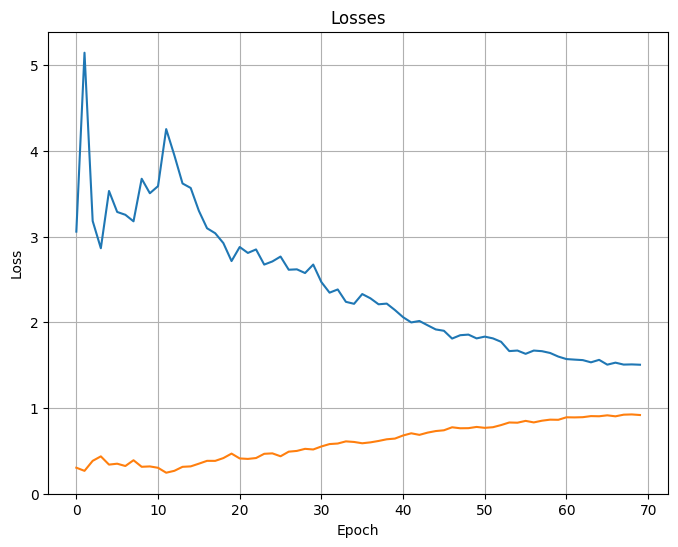

In [25]:
plot_losses(generator_losses, discriminator_losses)

### GIF


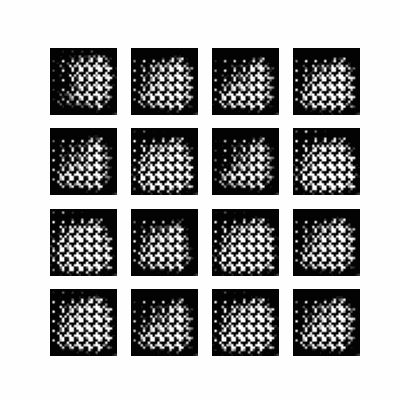

In [39]:
#embed.embed_file(create_gif("fashion"))
embed.embed_file("fashion.gif")

### Interpolation

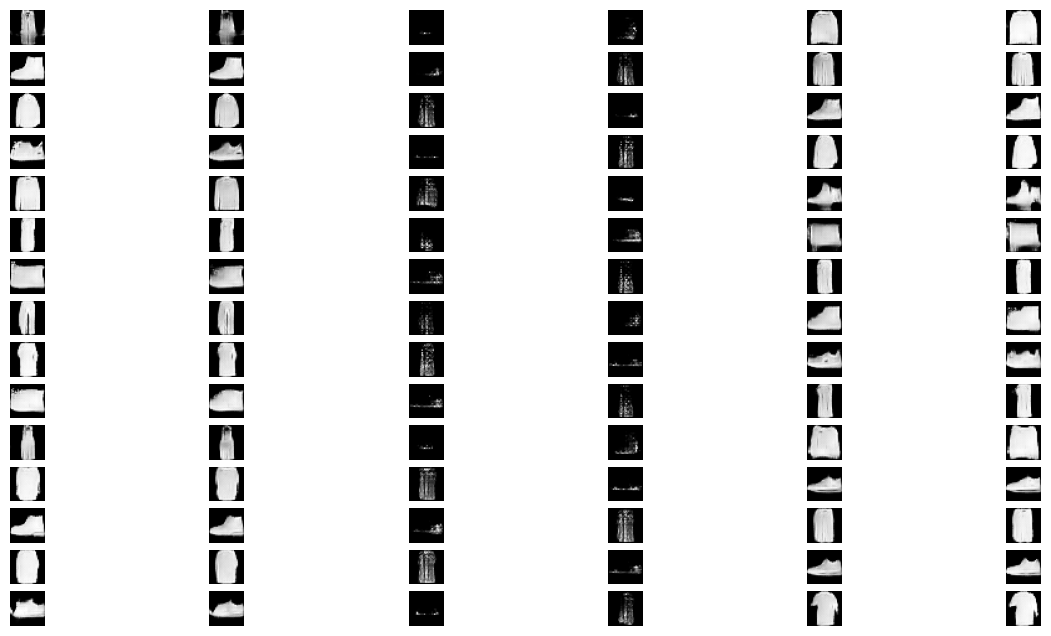

In [30]:
z_axis_interpolation(g, seed, 6)

# Thank you for your attention!